# Projet Télédétection : Landes de Bretagne

## Partie 1 : Visualisation des échantillons

### Nombre d'échantillons

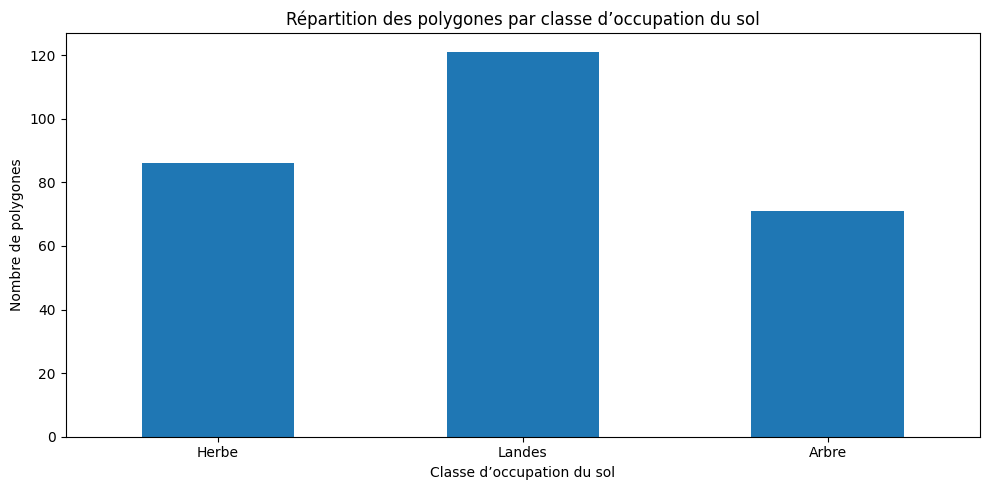

In [2]:
# --- Nombre de polygones par classe ---

import geopandas as gpd
import matplotlib.pyplot as plt
import os

os.makedirs("/home/onyxia/work/results/figure", exist_ok=True)  #Création du dossier results

gdf = gpd.read_file("../data/projet_eval/PI_strates_bretagne_32630.shp")   #Chargement en gdf pour le plot

classe = "strate"
counts = gdf[classe].value_counts().sort_index()    #comptage

#dictionnaire de correspondance code / classe pour les étiquettes
labels_strates = {  
    1: "Sol nu",
    2: "Herbe",
    3: "Landes",
    4: "Arbre"
}

#Remplacer les codes par les noms
counts.index = counts.index.map(labels_strates)

plt.figure(figsize=(10, 5))
counts.plot(kind="bar")

plt.xlabel("Classe d’occupation du sol")
plt.ylabel("Nombre de polygones")
plt.title("Répartition des polygones par classe d’occupation du sol")
plt.xticks(rotation=0)  #étiquettes horizontales

plt.tight_layout()

plt.savefig("../results/figure/diag_baton_nb_poly_by_class.png", dpi=300)

plt.show()

On remarque que l'échantillon ne contient pas un seul polygone de la classe "Sol nu". La classe "Landes" est la plus représentée tandis que les strates "Herbe" et "Arbre" sont à peu près équivalentes en nombre de polygones.

0...10...20...30...40...50...60...70...80...90...100 - done.


/opt/python/lib/python3.13/site-packages/osgeo/gdal.py:330: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


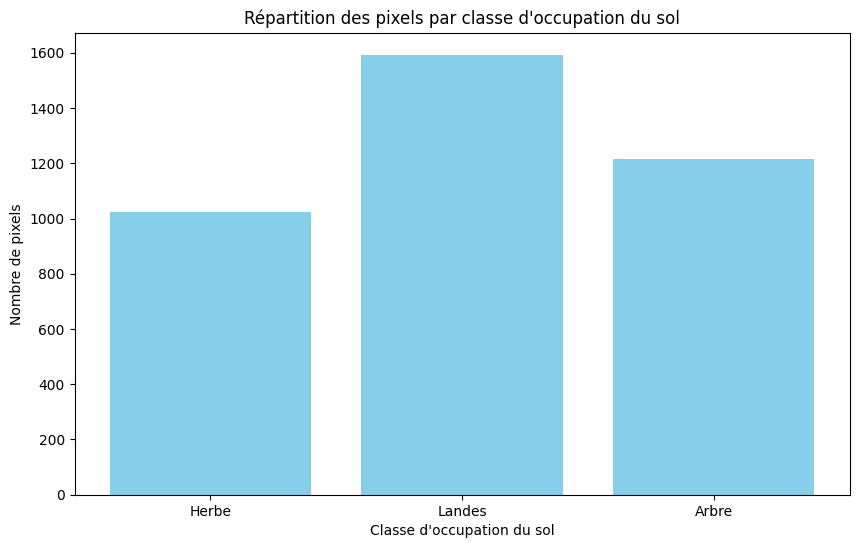

In [3]:
import os
from osgeo import gdal
import sys
from my_function import rasterization   #Appel fonction
import numpy as np
import matplotlib.pyplot as plt

sys.path.append('/home/onyxia/work')

# --- Nombre de pixels par classe ---

# Rasterisation
# Définition des paramètres
field_name = "strate"
sptial_resolution = 10
in_vector = "../data/projet_eval/PI_strates_bretagne_32630.shp"
out_image = "PI_strates_bretagne_32630.tif"

rasterization(in_vector, out_image, field_name, sptial_resolution)

# Comptage
# Ouvrir le raster
dataset = gdal.Open(out_image)

band = dataset.GetRasterBand(1)
data = band.ReadAsArray()

values, counts = np.unique(data, return_counts=True)

# Filtrer la classe 0 qui correspond à nodata
mask = values != 0
values = values[mask]
counts = counts[mask]

# Remplacer les codes par les noms
labels = [labels_strates.get(val, f"Classe {val}") for val in values]

# Réalisation du barplot
plt.figure(figsize=(10, 6))
plt.bar(labels, counts, color='skyblue')
plt.xlabel("Classe d'occupation du sol")
plt.ylabel("Nombre de pixels")
plt.title("Répartition des pixels par classe d'occupation du sol")

plt.savefig("../results/figure/diag_baton_nb_pix_by_class.png", dpi=300)

plt.show()


La distribution des pixels suit celle des polygones : La strate "Landes" est la plus représentée, et il n'y a aucun pixel de sol nu.

### Phénologie des strates, mise en évidence des landes

In [4]:
from libsigma import read_and_write

ds = gdal.Open("../data/projet_eval/bretagne_24-25_B03.tif")
read_and_write.get_pixel_size(ds, verbose=True)

print("Projection : ", ds.GetProjection())

raster_band = ds.GetRasterBand(1)
print("Nodata : ", raster_band.GetNoDataValue())


Pixel Size = (10.0, -10.0)
Projection :  PROJCS["WGS 84 / UTM zone 30N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-3],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32630"]]
Nodata :  None


Nous pouvons voir que le raster de la bande 3 pour Bretagne 2024-2025 est déjà dans la bonne projection et a déjà la bonne taille de pixel par rapport à ce qui est demandé. Cependant il n'y a pas de valeur de NoData définie, donc il faudra la préciser.

In [ ]:
import my_function


B03_path = "../data/projet_eval/bretagne_24-25_B03.tif"
B05_path = "../data/projet_eval/bretagne_24-25_B05.tif"

B03 = read_and_write.load_img_as_array(B03_path)
B05 = read_and_write.load_img_as_array(B05_path)

reference = gdal.Open(B03_path)

# Calcul NARI
nari = (1/B03 - 1/B05)/(1/B03 + 1/B05)

nodata = -9999
nari = np.where(np.isfinite(nari), nari, nodata)    #Remplacement de -inf, nan... par nodata

# Ecriture du raster
my_function.write_image_nd(
    "../results/ARI_serie_temp.tif", 
    array=nari, 
    data_set=reference, 
    gdal_dtype=gdal.GDT_Float32,
    nodata=-9999
    )
